In [1]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
from barnacle import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import string
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from barnacle.tensors import SparseCPTensor


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300


In [3]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))

# unique bin function
def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data

In [50]:
# select the cluster to examine

genus = 'syn'
rank = 30
lamb = 10. 
cluster = 18
bootstraps = [0, 1]
replicates = ['A', 'B', 'C']

# determined in component-robustness.ipynb analysis
best_reps = {
    'pro': {'rank': 30, 'lambda': 1., 'boot': 1, 'rep': 'C'}, 
#     'pro': {'rank': 25, 'lambda': 10., 'boot': 0, 'rep': 'A'}, 
    'syn': {'rank': 30, 'lambda': 1., 'boot': 1, 'rep': 'C'}
}

datapath = Path('../../../data/fitting-test/{}/'.format(genus))


In [51]:
# fetch sample metatdata and shuffled sample label inputs

filepath_metadata_sample = '../../../data/metadata/sample_metadata_merged.csv'
metadata_sample_df = pd.read_csv(filepath_metadata_sample).fillna('')
metadata_sample_df['datetime'] = pd.to_datetime(metadata_sample_df['datetime'])

# collect sample names of each bootstrap/replicate pair
samplenames = {}
for boot in bootstraps:
    samplenames[boot] = {}
    for rep in replicates:
        ds = xr.open_dataset(datapath / 'bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(boot, rep, rep))
        samplenames[boot][rep] = ds.samplename.data

# collect common samplenames (present in each bootstrap)
samplenames['common'] = reduce(
    np.intersect1d, 
    [samplenames[b][r] for b, r in list(itertools.product(bootstraps, replicates))]
)

tensor_ds = xr.open_dataset(datapath / 'bootstrap{}/dataset_bootstrap_{}.nc'.format(bootstraps[0], bootstraps[0]))

tensor_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...
Attributes:
    shuffle_seed:  1336149668

In [52]:
# import fitted models

cps = {}    # model as saved on computer
aligned_cps = {}    # aligned to best representative, all samples present
subset_aligned_cps = {}    # aligned to best representative, subset to just common samples

# read in best representative reference cp
path_ref_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
    best_reps[genus]['boot'], best_reps[genus]['rep'], best_reps[genus]['rank'], best_reps[genus]['lambda']
)
cps['ref'] = tl.cp_normalize(load_cp_tensor(datapath / path_ref_cp))
# subset ref cp to common samplenames
idx = np.where(np.isin(
    samplenames[best_reps[genus]['boot']][best_reps[genus]['rep']], samplenames['common']
))[0]
subset_aligned_cps['ref'] = subset_cp_tensor(cps['ref'], {2: idx})
# arrange components in descending order of explained variance
subset_aligned_cps['ref'] = tlviz.factor_tools.permute_cp_tensor(
    subset_aligned_cps['ref'], 
    consider_weights=False
)

# read in the rest of the cp tensor models
for boot in bootstraps:
    cps[boot] = {}
    aligned_cps[boot] = {}
    subset_aligned_cps[boot] = {} 
    for rep in replicates:
        path_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
            boot, rep, rank, lamb
        )
        # store normalized cp tensor to cps
        cps[boot][rep] = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
        # pull out aligned cps
        idx = np.where(np.isin(samplenames[boot][rep], samplenames['common']))[0]
        subset_aligned_cps[boot][rep] = subset_cp_tensor(cps[boot][rep], {2: idx})
        # permute components to line up with best representative reference cp
        perm = tlviz.factor_tools.get_cp_permutation(
            subset_aligned_cps[boot][rep], 
            reference_cp_tensor=subset_aligned_cps['ref'], 
            consider_weights=False
        )
        subset_aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
            subset_aligned_cps[boot][rep], 
            permutation=perm
        )
        aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
            cps[boot][rep], 
            permutation=perm
        )

print(cps[0]['A'])
print(aligned_cps[0]['A'])
print(subset_aligned_cps[0]['A'])


(weights, factors) : rank-30 CPTensor of shape (6161, 6, 69)
(weights, factors) : rank-30 CPTensor of shape (6161, 6, 69)
(weights, factors) : rank-30 CPTensor of shape (6161, 6, 55)


# aggregate weights across bootstraps for selected component

In [53]:
# aggregate weights for each mode across all bootstraps

# arrange gene data
labels = tensor_ds.ortholog.data
annotations = tensor_ds.annotation.data
annotation_dict = dict(zip(labels, annotations))
data = []
for boot in bootstraps:
    for rep in replicates:
        cp = aligned_cps[boot][rep]
        weights = SparseCPTensor(cp).get_components()[cluster-1].factors[0].flatten()
        support = (weights != 0)
        data.append({
            'bootstrap': boot, 
            'replicate': rep, 
            **dict(zip(labels[support], weights[support]))
        })
gene_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='cycog', value_name='weight')
counts = gene_df.groupby('cycog').weight.count()
gene_df['% bootstraps'] = gene_df['cycog'].map(counts) / (len(bootstraps) * len(replicates))
gene_df['annotation'] = gene_df['cycog'].map(annotation_dict)

# arrange taxon data
labels = [l if l != 'CDR2' else 'CRD2' for l in tensor_ds.clade.data]    # fix CRD2
data = []
for boot in bootstraps:
    for rep in replicates:
        cp = aligned_cps[boot][rep]
        weights = SparseCPTensor(cp).get_components()[cluster-1].factors[1].flatten()
        data.append({
            'bootstrap': boot, 
            'replicate': rep, 
            **dict(zip(labels, weights))
        })
taxon_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='ecotype', value_name='weight')

# arrange sample data
data = []
for boot in bootstraps:
    for rep in replicates:
        labels = samplenames[boot][rep]
        cp = aligned_cps[boot][rep]
        weights = SparseCPTensor(cp).get_components()[cluster-1].factors[2].flatten()
        data.append({
            'bootstrap': boot, 
            'replicate': rep, 
            **dict(zip(labels, weights))
        })
sample_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='samplename', value_name='weight')
sample_df = pd.merge(left=sample_df, right=metadata_sample_df, on='samplename', how='left')

gene_df.groupby('cycog')['% bootstraps'].mean().value_counts()

0.166667    42
0.333333    31
0.500000    16
0.666667    15
0.833333     9
1.000000     6
Name: % bootstraps, dtype: int64

# Plot weights

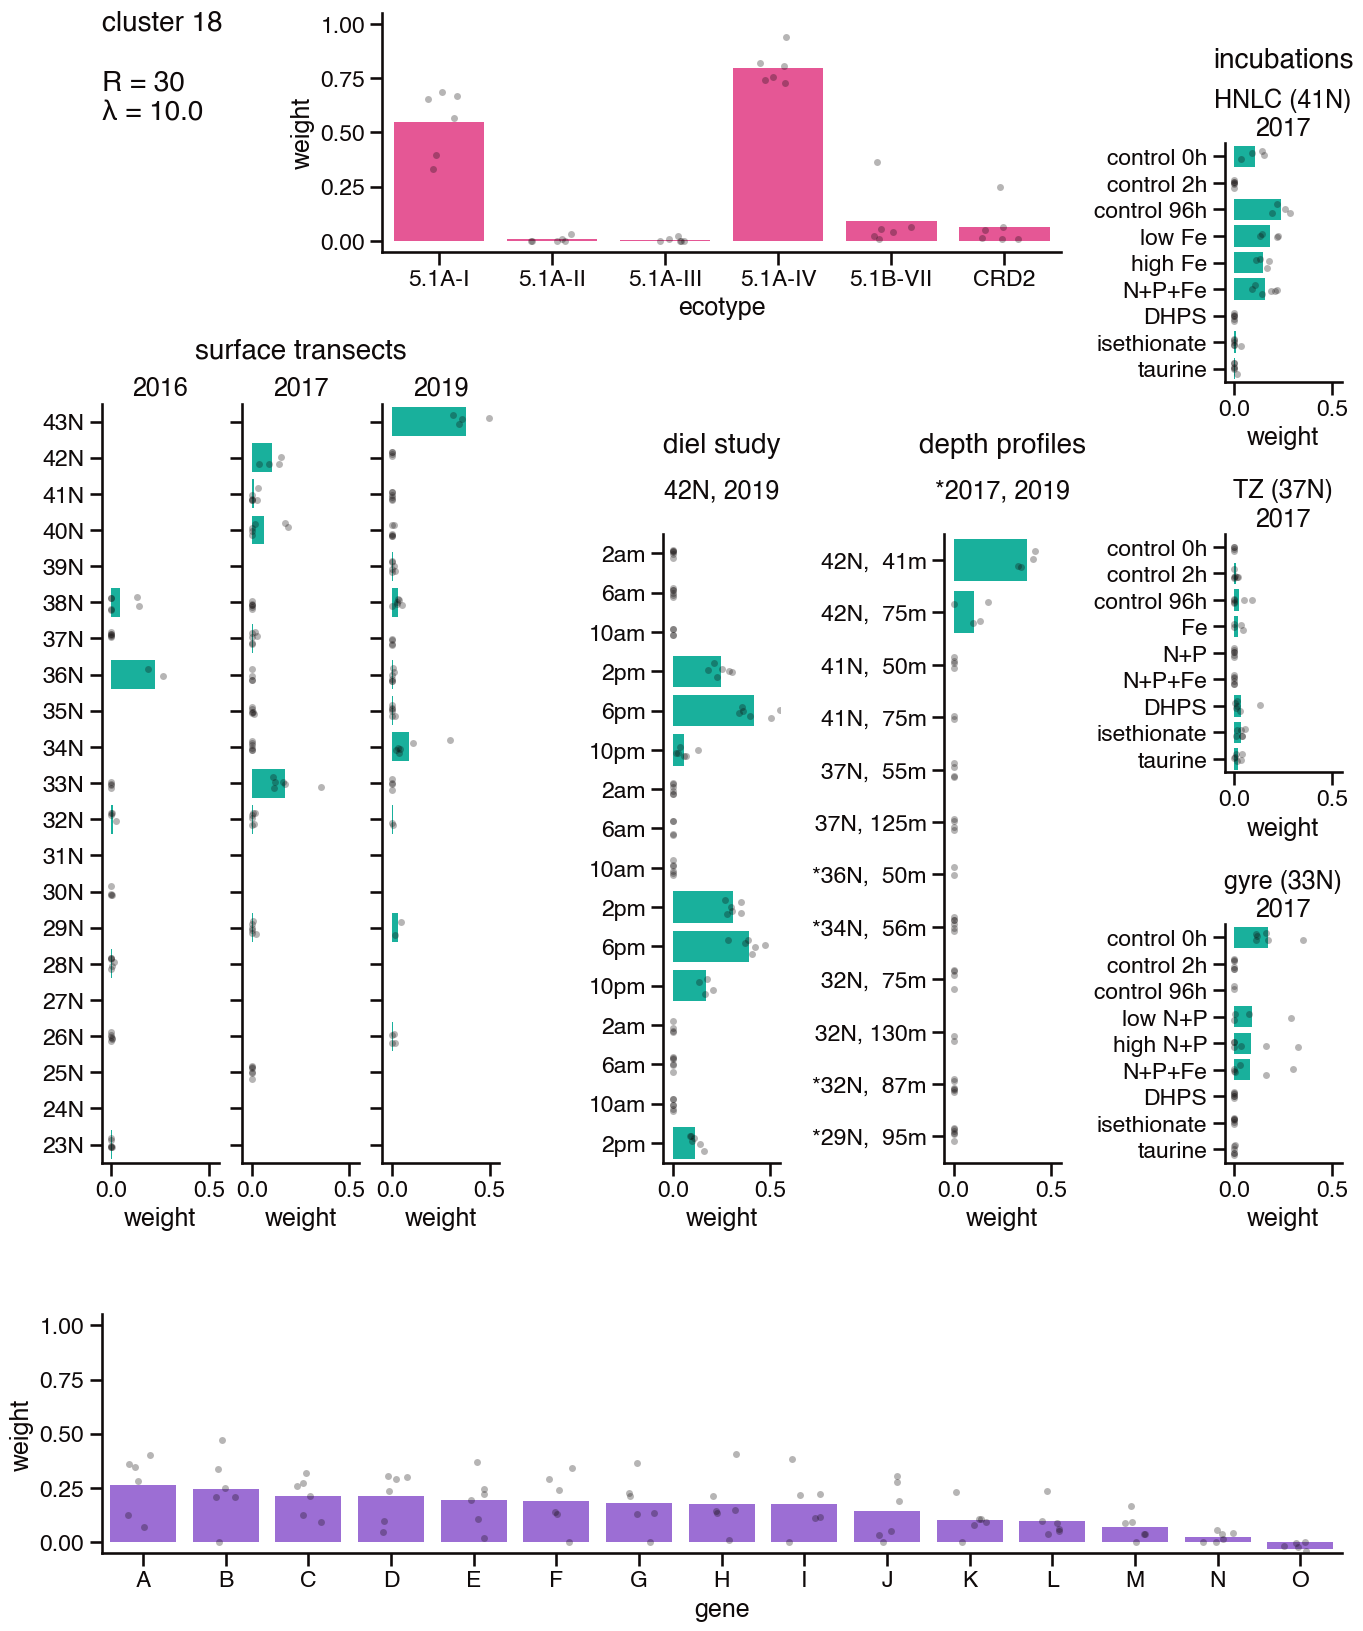

,gene,cycog,annotation,weight,% bootstraps
0,A,60000041,cytochrome c oxidase subunit 1,0.264923,1.000000
1,B,60000067,cytochrome c oxidase subunit 2,0.246514,0.833333
2,C,60000143,starch phosphorylase,0.214758,1.000000
3,D,60000194,cytochrome c oxidase assembly protein subunit 15,0.213237,1.000000
4,E,60001088,ferredoxin protochlorophyllide reductase subun...,0.192969,1.000000
5,F,60003215,glyceraldehyde-3-phosphate dehydrogenase (NAD+),0.191079,0.833333
6,G,60000170,protoheme IX farnesyltransferase,0.178871,0.833333
7,H,60000132,cobaltochelatase CobN subunit,0.176604,1.000000
8,I,60000595,transaldolase,0.174929,0.833333
9,J,60000247,NADH dehydrogenase subunit M,0.142176,0.833333


In [54]:
# sample figure

# figure specs
max_genes = 20 # show top n genes only in figure (sorted by weight)
thold_bootstrap = 0.8 # only include genes in which at least this proportion of bootstraps include them in cluster
sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
fig = plt.figure(figsize=(16, 20))
rows = 12
cols = 9
grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
annot_kwgs = {
    'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
}
incubation_treatment_order = {
    'HNLC': ['control 0h', 'control 2h', 'control 96h', 'low Fe', 'high Fe', 'N+P+Fe', 'DHPS', 'isethionate', 'taurine'], 
    'TZ': ['control 0h', 'control 2h', 'control 96h', 'Fe', 'N+P', 'N+P+Fe', 'DHPS', 'isethionate', 'taurine'], 
    'gyre': ['control 0h', 'control 2h', 'control 96h', 'low N+P', 'high N+P', 'N+P+Fe', 'DHPS', 'isethionate', 'taurine']
}

# helper function for plotting weights as barplot with datapoints scattered on top
def plot_weights(df, x, y, ax, order=None, color=sns.color_palette()[0], orient='v'):
    sns.barplot(
        data=df, x=x, y=y, color=color, orient=orient, order=order, errorbar=None, ax=ax
    )
    sns.stripplot(
        data=df, x=x, y=y, color=line_color, alpha=.3, size=5, jitter=.2, orient=orient, order=order, ax=ax
    ) 

# annotate with information about the cluster
axis = plt.subplot(grid[0, 0])
axis.set_axis_off()
axis.annotate('cluster {}\n\nR = {}\nλ = {}'.format(cluster, rank, lamb), xy=(0., 0.5), xycoords='axes fraction', 
              va='center', ha='left', fontsize=20)
# axis = plt.subplot(grid[1:3, 0])
# axis.set_axis_off()
# n_genes, _ = np.histogram(gene_df.groupby('cycog')['% bootstraps'].mean(), bins=[0, 0.5, 0.8, 1, 1])
# table = axis.table(cellText=np.array([['<50', '50-80', '80-100', '100'], n_genes]).T, rowLabels=None, 
#            colLabels=['%boots', 'genes'], cellLoc='center', colLoc='center', loc='center')
# table.auto_set_font_size(False)
# table.set_fontsize(16)


# plot ecotype data
axis = plt.subplot(grid[0:2, 2:7])
# axis.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
plot_weights(
    df=taxon_df, x='ecotype', y='weight', ax=axis, color=sns.color_palette()[3]
)
axis.set(ylim=[-0.05, 1.05])
axis.tick_params(axis='x', labelrotation=0)


# plot surface transect data
n_bins = 21
bounds = (23, 43)
for i, year in enumerate([2016, 2017, 2019]):
    axis = plt.subplot(grid[3:9, i])
    if i == 1:
        axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
#         axis.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
    # get data together
    plot_df = sample_df[sample_df['samplegroup'] == 'surface transect']
    plot_df = plot_df[plot_df['year'] == year]
    latitudes = plot_df[
        ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
    lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
    plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
    # make figure
    plot_weights(
        df=plot_df, x='weight', y='lat_idx', ax=axis, order=np.arange(n_bins), 
        color=sns.color_palette()[2], orient='h'
    )
    # set labels and such
    axis.set(xlim=sample_weight_range, ylabel='', xlabel='weight', title=year)
    if not i:
        axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])
    else:
        axis.tick_params(left=True, labelleft=False)

# plot diel data
axis = plt.subplot(grid[4:9, 4])
# axis.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
axis.annotate('diel study', xy=(0.5, 1.14), xycoords='axes fraction', va='center', ha='center', fontsize=20)
# get data together
plot_df = sample_df[sample_df['samplegroup'] == 'diel study'].sort_values('datetime')
n_samples = plot_df['samplename'].nunique()
plot_df['idx'] = plot_df['samplename'].map(dict(zip(plot_df['samplename'].unique(), np.arange(n_samples))))
plot_weights(
    df=plot_df, x='weight', y='idx', ax=axis, color=sns.color_palette()[2], orient='h'
)
axis.set(xlim=sample_weight_range, ylabel='', title='42N, 2019\n')
axis.set_yticks(np.arange(n_samples), plot_df[['samplename', 'timeclass']].drop_duplicates()['timeclass']);

# plot depth data
axis = plt.subplot(grid[4:9, 6])
# axis.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
axis.annotate('depth profiles', xy=(0.5, 1.14), xycoords='axes fraction', va='center', ha='center', fontsize=20)
# get data together
plot_df = sample_df[sample_df['samplegroup'] == 'depth profiles'].sort_values(
    ['latitude', 'depth'], ascending=[False, True])
n_samples = plot_df['samplename'].nunique()
plot_df['idx'] = plot_df['samplename'].map(dict(zip(plot_df['samplename'].unique(), np.arange(n_samples))))
plot_weights(
    df=plot_df, x='weight', y='idx', ax=axis, color=sns.color_palette()[2], orient='h'
)
axis.set(xlim=sample_weight_range, ylabel='', title='*2017, 2019\n')
label_df = plot_df[['samplename', 'depth', 'latitude', 'year']].drop_duplicates()
year_dict = {2017: '*', 2019: ''}
labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]
axis.set_yticks(np.arange(n_samples), labels);

# plot incubation data
for i, condition in enumerate(['HNLC', 'TZ', 'gyre']):
    axis = plt.subplot(grid[3*i+1:3*(i+1), 8])
    if not i:
        axis.annotate('incubations', xy=(0.5, 1.35), xycoords='axes fraction', 
                      va='center', ha='center', fontsize=20)
    # get data together
    plot_df = sample_df[sample_df['condition'] == condition]
    plot_weights(
        df=plot_df, x='weight', y='treatment', ax=axis, color=sns.color_palette()[2], 
        order=incubation_treatment_order[condition], orient='h'
    )
    axis.set(xlim=sample_weight_range, ylabel='', 
             title='{} ({})\n2017'.format(condition, {'HNLC': '41N', 'TZ': '37N', 'gyre': '33N'}[condition]))

    
# plot gene data
axis = plt.subplot(grid[10:, :])
# axis.annotate('E', xy=(-0.2, 1.15), **annot_kwgs)
plot_df = gene_df[gene_df['% bootstraps'].ge(thold_bootstrap)]
# fill in nas
plot_df = plot_df.fillna(0.0)
# find top genes by mean weight
top_genes = plot_df.groupby('cycog').weight.mean().sort_values(ascending=False).head(max_genes).index
plot_df = plot_df[plot_df['cycog'].isin(top_genes)].reset_index()
# sort by mean weight
gene_labels = list(string.ascii_uppercase)[:max_genes]
plot_df['gene'] = plot_df['cycog'].map(dict(zip(top_genes, gene_labels)))
plot_df = plot_df.sort_values('gene')
# render plot
plot_weights(
    df=plot_df, x='gene', y='weight', ax=axis, color=sns.color_palette()[0]
)
axis.set(ylim=[-0.05, 1.05])

# save/show figure
fig.savefig('profile-cluster{}.png'.format(cluster), bbox_inches='tight')
plt.show()

# show gene name key after figure
gene_key_df = gene_df.fillna(0.0).groupby(['cycog', 'annotation'])[['weight', '% bootstraps']].mean().reset_index()
gene_key_df['gene'] = gene_key_df['cycog'].map(dict(zip(top_genes, gene_labels)))
gene_key_df = gene_key_df[
    ['gene', 'cycog', 'annotation', 'weight', '% bootstraps']
].sort_values(['gene', '% bootstraps', 'weight'], ascending=[True, False, False]).reset_index(drop=True).fillna('')
gene_key_df.head(50)
